In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Gold_Price_Dataset.csv')
df_main.head()

,Name,US dollar,Euro,Japanese yen,Pound sterling,Canadian dollar,Swiss franc,Indian rupee,Chinese renmimbi,US dollar.1,Turkish lira,Saudi riyal,Indonesian rupiah,UAE dirham,Thai baht,Vietnamese dong,Egyptian pound,Korean won,Euro.1,Russian ruble,US dollar.2,South African rand,Chinese renmimbi.1,Canadian dollar.1,Australian dollar
0,29-12-1978,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
1,01-01-1979,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
2,02-01-1979,226.8,137.3,43164.9,111.5,263.7,359.6,1792.9,NaN,226.8,NaN,735.6,138160.5,851.3,4454.6,NaN,NaN,107470.0,137.3,NaN,226.8,194.6,NaN,263.7,193.6
3,03-01-1979,218.6,134.0,43717.9,108.0,264.4,365.9,1802.2,NaN,218.6,NaN,739.4,138877.0,855.7,4477.7,NaN,NaN,108027.4,134.0,NaN,218.6,192.2,NaN,264.4,193.0
4,04-01-1979,223.2,136.8,43674.9,110.7,264.1,366.4,1811.7,NaN,223.2,NaN,743.4,139616.3,860.3,4501.5,NaN,NaN,108602.5,136.8,NaN,223.2,193.0,NaN,264.1,194.6


In [4]:
df_main.shape

(10901, 25)

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10901 non-null  object 
 1   US dollar           10901 non-null  float64
 2   Euro                10901 non-null  float64
 3   Japanese yen        10899 non-null  float64
 4   Pound sterling      10901 non-null  float64
 5   Canadian dollar     10899 non-null  float64
 6   Swiss franc         10899 non-null  float64
 7   Indian rupee        10899 non-null  float64
 8   Chinese renmimbi    9330 non-null   float64
 9   US dollar.1         10901 non-null  float64
 10  Turkish lira        9856 non-null   float64
 11  Saudi riyal         10899 non-null  float64
 12  Indonesian rupiah   10899 non-null  float64
 13  UAE dirham          10899 non-null  float64
 14  Thai baht           10899 non-null  float64
 15  Vietnamese dong     8050 non-null   float64
 16  Egyp

In [6]:
time = pd.date_range(start='12/29/1978',periods=10901,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Name'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [7]:
df = df_main[['US dollar']]

In [8]:
df.shape

(10901, 1)

In [9]:
df.isnull().sum()

US dollar    0
dtype: int64

In [10]:
df.columns=['USD']

In [11]:
df.head()

,USD
time_stamp,
1978-12-29,226.0
1979-01-01,226.0
1979-01-02,226.8
1979-01-03,218.6
1979-01-04,223.2


In [12]:
df.tail()

,USD
time_stamp,
2020-10-05,1909.6
2020-10-06,1913.4
2020-10-07,1884.5
2020-10-08,1887.5
2020-10-09,1923.3


In [13]:
plt.rcParams['figure.figsize'] = [15,8]

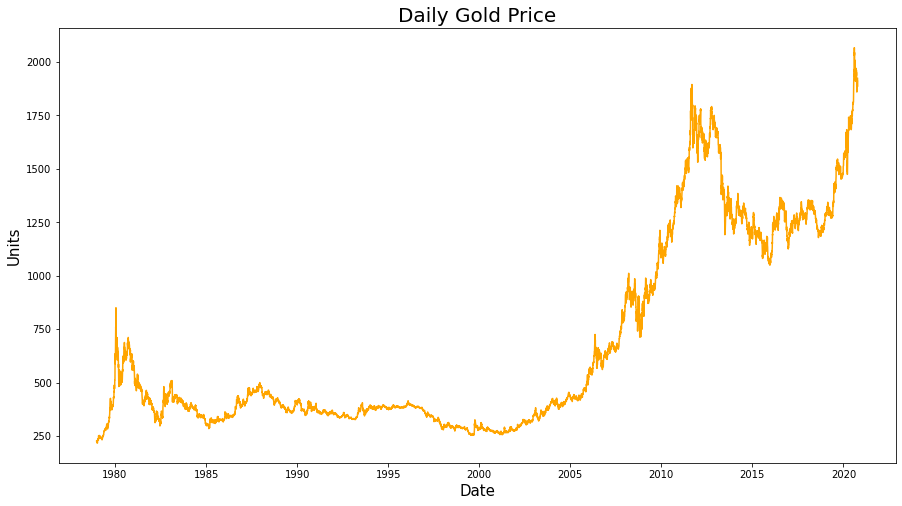

In [14]:
plt.plot(df,color='orange')
plt.title('Daily Gold Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [15]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [44]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['USD'] = df['USD'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [45]:
#Split data set into testing dataset and train dataset
train_size = 9801
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(9797, 1, 4)
(9797,)
(1096, 1, 4)
(1096,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [22]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [23]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer',min_value=8,max_value=256,step=8), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=8,max_value=256,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [30]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [32]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 10 Complete [00h 05m 23s]
val_mape: 0.6051326990127563

Best val_mape So Far: 0.5875175595283508
Total elapsed time: 00h 50m 48s
INFO:tensorflow:Oracle triggered exit


In [33]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 40
first_recurrent_dropout: 0.2
dense_layer: 128
Dropout_rate: 0.1
learning_rate: 0.00041262424129007364
Score: 0.5875175595283508
Trial summary
Hyperparameters:
rnn_layer: 128
first_recurrent_dropout: 0.2
dense_layer: 152
Dropout_rate: 0.0
learning_rate: 0.002016731956984042
Score: 0.5889031291007996
Trial summary
Hyperparameters:
rnn_layer: 184
first_recurrent_dropout: 0.3
dense_layer: 8
Dropout_rate: 0.0
learning_rate: 0.015629230639366914
Score: 0.5985832214355469
Trial summary
Hyperparameters:
rnn_layer: 160
first_recurrent_dropout: 0.4
dense_layer: 176
Dropout_rate: 0.30000000000000004
learning_rate: 0.0004587913177291949
Score: 0.6015581488609314
Trial summary
Hyperparameters:
rnn_layer: 192
first_recurrent_dropout: 0.3
dense_layer: 120
Dropout_rate: 0.1
learning_rate: 0.0031676192175181784
Score: 0.6051326990127563
Trial summar

In [34]:
from warnings import filterwarnings
filterwarnings('ignore')

In [35]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40)                1800      
                                                                 
 dense (Dense)               (None, 128)               5248      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,177
Trainable params: 7,177
Non-trainable params: 0
_________________________________________________________________


In [36]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
model = Sequential()
model.add(SimpleRNN(32,activation='relu',input_dim = 4,recurrent_dropout=0.2))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000011262424129007364)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 200)

Epoch 1/200
307/307 [==============================] - 4s 5ms/step - loss: 209.8930 - mape: 209.8930 - val_loss: 206.4018 - val_mape: 206.4018
Epoch 2/200
307/307 [==============================] - 1s 4ms/step - loss: 191.1003 - mape: 191.1003 - val_loss: 193.5575 - val_mape: 193.5575
Epoch 3/200
307/307 [==============================] - 1s 3ms/step - loss: 172.1928 - mape: 172.1928 - val_loss: 181.0512 - val_mape: 181.0512
Epoch 4/200
307/307 [==============================] - 1s 3ms/step - loss: 154.6366 - mape: 154.6366 - val_loss: 169.4402 - val_mape: 169.4402
Epoch 5/200
307/307 [==============================] - 1s 3ms/step - loss: 138.2500 - mape: 138.2500 - val_loss: 158.3270 - val_mape: 158.3270
Epoch 6/200
307/307 [==============================] - 1s 3ms/step - loss: 122.7830 - mape: 122.7830 - val_loss: 147.8640 - val_mape: 147.8640
Epoch 7/200
307/307 [==============================] - 1s 4ms/step - loss: 108.9516 - mape: 108.9516 - val_loss: 138.1355 - val_mape: 138.1355

In [48]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [49]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 0.95 
Test MAPE : 0.71 


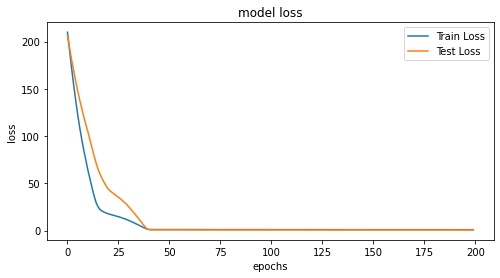

In [50]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [41]:
import seaborn as sns

In [51]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(9797,10893)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

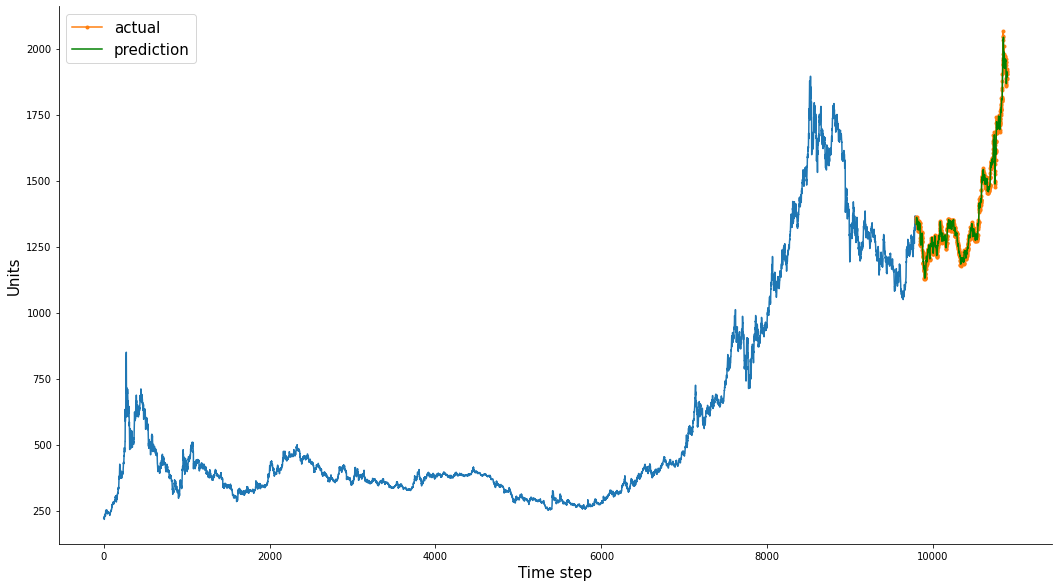

In [52]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)